In [1]:
using Images, LinearAlgebra

# 2. Output an Image

In [2]:
(image_width, image_height) = (200, 100)

(200, 100)

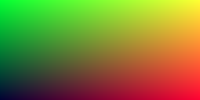

In [3]:
[RGB(i / image_width, j / image_height, 0.2) for j in image_height:-1:1, i in 1:image_width]

# 3. The Vec3 ~~Class~~ Array

In [4]:
x(vec) = vec[1]
y(vec) = vec[2]
z(vec) = vec[3];

In [5]:
color(i,j) = [i / image_width, j / image_height, 0.2]

color (generic function with 1 method)

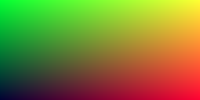

In [6]:
render() = [RGB(color(i,j)...) for j in image_height:-1:1, i in 1:image_width]
render()

# 4. Rays, a Simple Camera, and Background

In [7]:
module RayModule 

export Ray

struct Ray 
    origin
    direction
end

end

Main.RayModule

In [8]:
using .RayModule

In [9]:
at(ray::Ray, t) = ray.origin + t * ray.direction

at (generic function with 1 method)

In [10]:
function color(ray::Ray)
    unit_direction = normalize(ray.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 2 methods)

In [11]:
lower_left_corner = [-2, -1, -1]
horizontal = [4, 0, 0]
vertical = [0, 2, 0]
origin = [0, 0, 0];

In [12]:
function color(i, j) 
    u = i / image_width
    v = j / image_height
    r = Ray(origin, lower_left_corner + u * horizontal + v * vertical)
    color(r)
end

color (generic function with 2 methods)

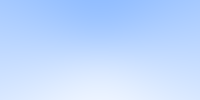

In [13]:
render()

# 5. Adding a Sphere

In [14]:
function hit_sphere(center, radius, r)
    oc = r.origin - center
    a = dot(r.direction, r.direction)
    b = 2 * dot(oc, r.direction)
    c = dot(oc, oc) - radius * radius
    discriminant = b * b - 4 * a * c
    discriminant > 0
end

hit_sphere (generic function with 1 method)

In [15]:
function color(r::Ray)
    if hit_sphere([0, 0, -1], 0.5, r)
        return [1, 0, 0]
    end
    unit_direction = normalize(r.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 2 methods)

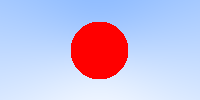

In [16]:
render()

# 6. Surface Normals and Multiple Objects

In [17]:
function hit_sphere(center, radius, r)
    oc = r.origin - center
    a = dot(r.direction, r.direction)
    b = 2 * dot(oc, r.direction)
    c = dot(oc, oc) - radius * radius
    discriminant = b * b - 4 * a * c
    if discriminant < 0
        -1
    else
        (-b - sqrt(discriminant)) / (2 * a)
    end
end

hit_sphere (generic function with 1 method)

In [18]:
function color(r::Ray)
    t = hit_sphere([0, 0, -1], 0.5, r)
    if t > 0
        n = normalize(at(r, t) - [0, 0, -1])
        return 0.5 * (n .+ 1)
    end
    unit_direction = normalize(r.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 2 methods)

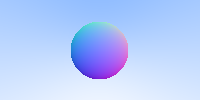

In [19]:
render()

In [20]:
function hit_sphere(center, radius, r)
    oc = r.origin - center
    a = norm(r.direction)^2
    half_b = dot(oc, r.direction)
    c = norm(oc)^2 - radius * radius
    discriminant = half_b * half_b - a * c
    
    if discriminant < 0
        -1
    else
        (-half_b - sqrt(discriminant)) / a
    end
end

hit_sphere (generic function with 1 method)

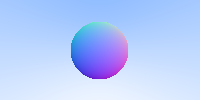

In [21]:
render()

In [22]:
module HitRecordModule

export HitRecord

mutable struct HitRecord
    p
    normal
    t
    front_face
    
    HitRecord() = new([0, 0, 0], [0, 0, 0], 0, false)
end

end

Main.HitRecordModule

In [23]:
using .HitRecordModule

In [24]:
function set_face_normal(rec:: HitRecord, r, outward_normal)
    rec.front_face = dot(r.direction, outward_normal) < 0
    rec.normal = if rec.front_face
        outward_normal 
    else
        -outward_normal
    end
end

set_face_normal (generic function with 1 method)

In [25]:
abstract type Hittable end

In [26]:
module SphereModule

export Sphere

struct Sphere <: Main.Hittable
    center
    radius
end

end

Main.SphereModule

In [27]:
using .SphereModule

In [28]:
function hit(sphere::Sphere, r, t_min, t_max, rec)
    oc = r.origin - sphere.center
    a = norm(r.direction)^2
    half_b = dot(oc, r.direction)
    c = norm(oc)^2 - sphere.radius * sphere.radius
    discriminant = half_b * half_b - a * c
    
    if discriminant > 0
        root = sqrt(discriminant)
        temp = (-half_b - root) / a
        if t_min < temp < t_max 
            rec.t = temp
            rec.p = at(r, rec.t)
            outward_normal = (rec.p - sphere.center) / sphere.radius
            set_face_normal(rec, r, outward_normal)
            return true
        end
        temp = (-half_b + root) / a
        if t_min < temp < t_max
            rec.t = temp
            rec.p = at(r, rec.t)
            outward_normal = (rec.p - sphere.center) / sphere.radius
            set_face_normal(rec, r, outward_normal)
            return true
        end
    end
    false
end

hit (generic function with 1 method)

In [29]:
module HittableListModule

export HittableList

struct HittableList <: Main.Hittable
    objects
end

end

Main.HittableListModule

In [30]:
using .HittableListModule

In [31]:
function hit(hittable_list::HittableList, r, t_min, t_max, rec)
    temp_rec = HitRecord()
    hit_anything = false
    closest_so_far = t_max
    
    for object in hittable_list.objects
        if hit(object, r, t_min, closest_so_far, temp_rec)
            hit_anything = true
            closest_so_far = temp_rec.t
            rec.p = temp_rec.p
            rec.normal = temp_rec.normal
            rec.t = temp_rec.t
            rec.front_face = temp_rec.front_face
        end
    end
    
    hit_anything
end

hit (generic function with 2 methods)

In [32]:
function color(r::Ray, world::Hittable)
    rec = HitRecord()
    if hit(world, r, 0, Inf, rec)
        return 0.5 * (rec.normal .+ 1)
    end
    unit_direction = normalize(r.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 3 methods)

In [33]:
world = HittableList([Sphere([0, 0, -1], 0.5), Sphere([0, -100.5, -1], 100)])

HittableList(Sphere[Sphere([0, 0, -1], 0.5), Sphere([0.0, -100.5, -1.0], 100)])

In [34]:
function color(i, j) 
    u = i / image_width
    v = j / image_height
    r = Ray(origin, lower_left_corner + u * horizontal + v * vertical)
    color(r, world)
end

color (generic function with 3 methods)

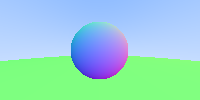

In [35]:
render()

# 7. Antialiasing

In [36]:
module CameraModule

export Camera

struct Camera
    origin
    lower_left_corner
    horizontal
    vertical
    
    Camera() = new([0, 0, 0], [-2, -1, -1], [4, 0, 0], [0, 2, 0])
end

end

Main.CameraModule

In [37]:
using .CameraModule

In [38]:
get_ray(camera:: Camera, u, v) = Ray(camera.origin, camera.lower_left_corner + u * camera.horizontal + v * camera.vertical - camera.origin)

get_ray (generic function with 1 method)

In [39]:
samples_per_pixel = 100;

In [40]:
cam = Camera()

Camera([0, 0, 0], [-2, -1, -1], [4, 0, 0], [0, 2, 0])

In [41]:
function color(i, j) 
    c = [0, 0, 0]
    for _ in 1:samples_per_pixel
        u = (i + rand()) / image_width
        v = (j + rand()) / image_height
        r = get_ray(cam, u, v)
        c += color(r, world)
    end
    c / samples_per_pixel
end

color (generic function with 3 methods)

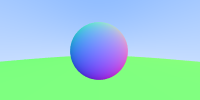

In [42]:
render()

# 8. Diffuse Materials

In [43]:
function random_in_unit_sphere()
    while true
        p = rand(-1:eps():1, 3)
        if norm(p)^2 > 1
            continue
        end
        return p
    end
end

random_in_unit_sphere (generic function with 1 method)

In [44]:
function color(r::Ray, world::Hittable, depth)
    rec = HitRecord()
    
    if depth <= 0
        return [0, 0, 0]
    end
    
    if hit(world, r, 0, Inf, rec)
        target = rec.p + rec.normal + random_in_unit_sphere()
        return 0.5 * color(Ray(rec.p, target - rec.p), world, depth - 1)
    end
    unit_direction = normalize(r.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 4 methods)

In [45]:
max_depth = 50;

In [46]:
function color(i, j) 
    c = [0, 0, 0]
    for _ in 1:samples_per_pixel
        u = (i + rand()) / image_width
        v = (j + rand()) / image_height
        r = get_ray(cam, u, v)
        c += color(r, world, max_depth)
    end
    c / samples_per_pixel
end

color (generic function with 4 methods)

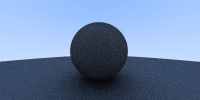

In [47]:
render()

In [48]:
function color(i, j) 
    c = [0, 0, 0]
    for _ in 1:samples_per_pixel
        u = (i + rand()) / image_width
        v = (j + rand()) / image_height
        r = get_ray(cam, u, v)
        c += color(r, world, max_depth)
    end
    sqrt.(c / samples_per_pixel)
end

color (generic function with 4 methods)

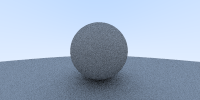

In [49]:
render()

In [50]:
function random_unit_vector()
    a = rand(0:eps():2pi)
    z = rand(-1:eps():1)
    r = sqrt(1 - z * z)
    [r*cos(a), r*sin(a), z]
end

random_unit_vector (generic function with 1 method)

In [51]:
function color(r::Ray, world::Hittable, depth)
    rec = HitRecord()
    
    if depth <= 0
        return [0, 0, 0]
    end
    
    if hit(world, r, 0.001, Inf, rec)
        target = rec.p + rec.normal + random_unit_vector()
        return 0.5 * color(Ray(rec.p, target - rec.p), world, depth - 1)
    end
    unit_direction = normalize(r.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 4 methods)

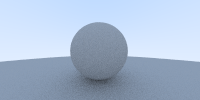

In [52]:
render()

In [53]:
function random_in_hemisphere(normal)
    in_unit_sphere = random_in_unit_sphere()
    if dot(in_unit_sphere, normal) > 0
        in_unit_sphere
    else
        -in_unit_sphere
    end
end

random_in_hemisphere (generic function with 1 method)

In [54]:
function color(r::Ray, world::Hittable, depth)
    rec = HitRecord()
    
    if depth <= 0
        return [0, 0, 0]
    end
    
    if hit(world, r, 0.001, Inf, rec)
        target = rec.p + random_in_hemisphere(rec.normal)
        return 0.5 * color(Ray(rec.p, target - rec.p), world, depth - 1)
    end
    unit_direction = normalize(r.direction)
    t = 0.5 * (y(unit_direction) + 1)
    (1 - t) * [1, 1, 1] + t * [0.5, 0.7, 1]
end

color (generic function with 4 methods)

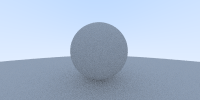

In [55]:
render()

# 9. Metal

In [56]:
abstract type Material end

In [57]:
module HitRecordModule

export HitRecord

mutable struct HitRecord
    p
    normal
    mat
    t
    front_face
    
    HitRecord() = new([0, 0, 0], [0, 0, 0], nothing, 0, false)
end

end

Main.HitRecordModule